# Regression: New York City Taxi Trip Duration

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import common

%matplotlib inline
# some settings for graphics
sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,4)})
# use this value where it is possible to indicate the random state
RANDOM_STATE = common.RANDOM_STATE

In [72]:
import os
path = 'New_York_City_Taxi_Trip_Duration.zip'
data = pd.read_csv(path, compression='zip')

In [73]:
# display table dimensions
data.shape

(1458644, 11)

In [74]:
# display 10 random rows
# data.sample(10)


In [75]:
# display descriptive statistics
# data.describe()

In [76]:
# data.describe(include='object')

In [77]:
# check if there are any columns containing unique values for each row. If so, drop them.
data = data.drop(columns=['id'])

In [78]:
# dropoff_datetime variable is added only to train data and thus cannot be used by the predictive model. Drop this feature.
data = data.drop(columns=['dropoff_datetime'])

In [79]:
# pickup_datetime contains date and time when the meter was engaged. Check the type of this feature and change it to datetime if it is another type.
data['pickup_datetime'].dtype

dtype('O')

In [80]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_datetime'].head()

0   2016-03-14 17:24:55
1   2016-06-12 00:43:35
2   2016-01-19 11:35:24
3   2016-04-06 19:32:31
4   2016-03-26 13:30:55
Name: pickup_datetime, dtype: datetime64[ns]

In [81]:
data.describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


In [82]:
# split data into train and test: 30% of data for test.
from sklearn.model_selection import train_test_split

X = data.drop(columns=['trip_duration'])
y = data['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [83]:
# data.trip_duration.hist();
X_train.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag'],
      dtype='object')

In [84]:
# data.trip_duration[data.trip_duration < data.trip_duration.quantile(0.99)].hist(bins=100);

In [85]:
def transform_target(y):
  return np.log1p(y).rename('log_'+y.name)

# print(y.dtype)
# y = transform_target(y)
# y_train = transform_target(y_train)
# y_test = transform_target(y_test)   

In [86]:
# y.hist(bins=100);

## Task 3. Baseline

To have some starting point, calculate the value of the RMSLE metric for the best constant prediction. What value could be considered as the best constant prediction?

In [87]:
# from sklearn.metrics import mean_squared_error
# 
# y_baseline = y_train.mean()
# print(f'Baseline prediction: {y_baseline:.2f} (transformed)')
# # np.expm1 is the inverse of log1p
# print(f'Baseline prediction: {np.expm1(y_baseline):.0f} (seconds)')
# 
# print(f'RMSLE on train data: {mean_squared_error([y_baseline]*len(y_train), y_train, squared=False):.3f}')
# print(f'RMSLE on train data: {mean_squared_error([y_baseline]*len(y_test), y_test, squared=False):.3f}')

In [88]:
# data['trip_duration'].mean()
y_train

1011257     844
178550     1001
551460     1048
1434271     784
1173610     732
           ... 
259178     1281
1414414     833
131932     1285
671155      389
121958     1570
Name: trip_duration, Length: 1021050, dtype: int64

In [89]:
# y_train_trip_duration = y_train[['trip_duration']
# y_train

In [90]:
import sqlite3
import os

db_dir = os.path.dirname(common.DB_PATH)
if not os.path.exists(db_dir):
    os.makedirs(db_dir)

print(f"Saving train and test data to a database: {common.DB_PATH}")
with sqlite3.connect(common.DB_PATH) as con:
    cur = con.cursor()
    cur.execute("DROP TABLE IF EXISTS X_train")
    cur.execute("DROP TABLE IF EXISTS X_test")
    cur.execute("DROP TABLE IF EXISTS y_train")
    cur.execute("DROP TABLE IF EXISTS y_test")
    X_train.to_sql(name='X_train', con=con, if_exists="replace")
    X_test.to_sql(name='X_test', con=con, if_exists="replace")
    y_train.to_sql(name='y_train', con=con, if_exists="replace")
    y_test.to_sql(name='y_test', con=con, if_exists="replace")
    y_train = pd.read_sql('SELECT * FROM y_train', con)

Saving train and test data to a database: C:\Users\brono\PycharmProjects\taxi_project_mlops_vFinal\data\taxi.db


In [91]:
y_train_trip_duration = y_train['trip_duration']
y_train = transform_target(y_train_trip_duration)
# y = transform_target(y)
# y_train = transform_target(y_train)
# y_test = transform_target(y_test)   

In [92]:
y_test

67250      1040
1397036     827
1021087     614
951424      867
707882     4967
           ... 
876090      826
832420      474
771092      478
1032031    1139
726290     1062
Name: trip_duration, Length: 437594, dtype: int64

In [93]:
print(f"Reading train data from the database: {common.DB_PATH}")
with sqlite3.connect(common.DB_PATH) as con:
    cur = con.cursor()
    res = cur.execute("SELECT * FROM pred_req_history LIMIT 1")
    display(res.fetchall())

Reading train data from the database: C:\Users\brono\PycharmProjects\taxi_project_mlops_vFinal\data\taxi.db


[(0,
  1,
  '2006-12-08 08:30:00',
  5,
  -13.985,
  80.748,
  -94.005,
  99.712,
  '2006-12-08',
  4,
  12,
  8,
  0,
  648.4868340741441)]

In [94]:
# Get the JSON representation of the first row
json_representation = X_test.head(1).to_json(orient='records', lines=True)

print(json_representation)


{"vendor_id":2,"pickup_datetime":1465371379000,"passenger_count":1,"pickup_longitude":-73.9856109619,"pickup_latitude":40.7359428406,"dropoff_longitude":-73.9803314209,"dropoff_latitude":40.7604675293,"store_and_fwd_flag":"N"}


## Task 4. `pickup_datetime`

### 4.1. Number of trips ~ date

How many trips are there every day? Display the relationship between the number of trips and the date (you can use `sns.countplot` function).

In [95]:
X['pickup_date'] = X['pickup_datetime'].dt.date
dates = X['pickup_date'].sort_values()
# g = sns.countplot(x=dates)
# g.set_major_formatter(dates.DateFormatter('%Y-%b'))

In [96]:
# plt.plot(X['pickup_date'].groupby(X['pickup_date']).count(), 'o-');

In [97]:
# plt.plot(X_train['pickup_datetime'].groupby(X_train['pickup_datetime'].dt.date).count(), 'o-', label='train')
# plt.plot(X_test['pickup_datetime'].groupby(X_test['pickup_datetime'].dt.date).count(), 'o-', label='test')
# plt.title('Number of trips by date')
# plt.legend(loc=0)
# plt.ylabel('Number of trips')
# plt.show()

**Question**: You might have noticed 2 periods with too few trips compared to the usual number of trips. Check the corresponding dates and see if there were any specific events in New York on those dates that might explain these low values.

In [98]:
df_abnormal_dates = X.groupby('pickup_date').size()
abnormal_dates = df_abnormal_dates[df_abnormal_dates < df_abnormal_dates.quantile(0.02)]
abnormal_dates 

pickup_date
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-05-30    5570
dtype: int64

<font color='yellowgreen'>your text here</font>

### 4.2. Number of trips ~ day of the week, hour of the day

Display two additional graphs: number of trips per weekday and number of journeys per hour of the day.

Display the number of trips per hour of the day and weekday (you can use the `sns.relplot` function).

For weekdays, display the names and not the numbers.

In [243]:
dict_weekday = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

weekday = X['pickup_datetime'].dt.weekday.map(dict_weekday).rename('weekday')
hourofday = X['pickup_datetime'].dt.hour.rename('hour')

In [244]:
# fig, ax = plt.subplots(1,2)
# sns.countplot(x=weekday, ax=ax[0])
# ax[0].set(xlabel='weekday')
# sns.countplot(x=hourofday, ax=ax[1])
# ax[1].set(xlabel='hour')
# ax[0].tick_params('x', labelrotation=45)
# ax[1].tick_params('x', labelrotation=90)
# plt.show()

In [245]:
# data_plot = X.groupby([weekday, hourofday]).size().rename('number of trips').reset_index()
# sns.relplot(data=data_plot, x='weekday', y='hour', size='number of trips', sizes=(10,500))
# plt.xticks(rotation=45)
# plt.show()

### 4.3. Number of trips ~ hour of the day for different months

Display on a single graph the dependency of the number of trips and the hour of the day for different months (one curve per month). The curves corresponding to different months should be displayed in different colours.

Also display a graph showing the dependency of the number of trips on the hour of the day for different days of the week (one curve per day of the week).

In [246]:
month = X.pickup_datetime.dt.month.rename('month')

In [247]:
# data_plot = X.groupby([month, hourofday]).size().rename('number of trips').reset_index()
# sns.relplot(data=data_plot, x='hour', y='number of trips', hue='month', kind='line', height=3, aspect=4)
# plt.show()

In [248]:
# data_plot = X.groupby([weekday, hourofday]).size().rename('number of trips').reset_index()
# sns.relplot(data=data_plot, x='hour', y='number of trips', hue='weekday', kind='line', height=3, aspect=4)
# plt.show()

Add your interpretation of the results.

In [254]:
# check the transformation
display(X['weekday'].value_counts().head())
display(X['month'].value_counts().head())
display(X['hour'].value_counts().head())
display(X['abnormal_period'].value_counts())

weekday
4    223533
5    220868
3    218574
2    210136
1    202749
Name: count, dtype: int64

month
3    256189
4    251645
5    248487
2    238300
6    234316
Name: count, dtype: int64

hour
18    90600
19    90308
21    84185
20    84072
22    80492
Name: count, dtype: int64

abnormal_period
0    1441959
1      16685
Name: count, dtype: int64

<font color='yellowgreen'>your text here</font>

### 4.4. Trip duration ~ date, day of the week, hour of the day

Display the distribution of the average target value by the date, the day of the week, and the time of the day.

In [249]:
# sns.barplot(x=X['pickup_date'], y=y)
# plt.show()

In [250]:
# sns.barplot(x=weekday, y=y)
# plt.show()

In [251]:
# sns.barplot(x=hourofday, y=y)
# plt.show()

**Question**: Display the graphs showing the dependency of the target variable on the day of the week and the time of day. What happens to the target variable during the two special periods seen before? Why? Are there any trends in the graph of `log_trip_duration` in relation to the day of the year?

In [252]:
# fig, ax = plt.subplots(1,2)
# 
# data_plot0 = X.groupby([weekday, hourofday]).size().rename('number of trips').reset_index()
# sns.scatterplot(data=data_plot0, x='weekday', y='hour', size='number of trips', sizes=(10,500), ax=ax[0])
# ax[0].set_title('Number of trips')
# ax[0].tick_params('x', labelrotation=45)
# ax[0].legend(loc="upper right")
# 
# data_plot1 = y.groupby([weekday, hourofday]).mean().rename('mean_target').reset_index()
# sns.scatterplot(data=data_plot1, x='weekday', y='hour', size='mean_target', sizes=(10,500), ax=ax[1])
# ax[1].set_title('Mean target')
# ax[1].tick_params('x', labelrotation=90)
# ax[1].legend(loc="upper right")
# 
# plt.show()

<font color='yellowgreen'>your text here</font>

### 4.5. New features

Add new variables based on `pickup_datetime`:

1.   Day of week
2.   Month
3.   Time of day
4.   If the period is "abnormal" (two binary variables for two periods detected)
5.   Day of the year

In [253]:
def step1_add_features(X):
  res = X.copy()
  res['weekday'] = res['pickup_datetime'].dt.weekday
  res['month'] = res['pickup_datetime'].dt.month
  res['hour'] = res['pickup_datetime'].dt.hour
  res['abnormal_period'] = res['pickup_datetime'].dt.date.isin(abnormal_dates.index).astype(int)
  return res

X = step1_add_features(X)
X_train = step1_add_features(X_train)
X_test = step1_add_features(X_test)

**Question**: Which of the variables should be considered as categorical and which as numerical? Why?

<font color='yellowgreen'>your text here</font>

In [255]:
X

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,weekday,month,hour,abnormal_period
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,2016-03-14,0,3,17,0
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,2016-06-12,6,6,0,0
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2016-01-19,1,1,11,0
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,2016-04-06,2,4,19,0
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,2016-03-26,5,3,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,2016-04-08,4,4,13,0
1458640,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,2016-01-10,6,1,7,0
1458641,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,2016-04-22,4,4,6,0
1458642,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,2016-01-05,1,1,15,0


### 4.6. Ridge regression

* Use only the features we have worked with up to now.
* Encode categorical features using `OneHotEncoder`.
* Scale numerical features using the `StandardScaler`.
* Train Ridge regression with the default settings.

In [256]:
X.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_date', 'weekday', 'month', 'hour',
       'abnormal_period'],
      dtype='object')

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [258]:
num_features = ['abnormal_period', 'hour']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

Train RMSE = 0.7929
Test RMSE = 3332.7218
Test R2 = -0.0880


## Task 5. Coordinates analysis

Below you will find the definition of the `show_circles_on_map` function, which displays the start and end points on a map. Examples of how to call this function can also be found below. We don't pass all the available data to the function, but only a sample, to reduce execution time.

### 5.1. Folium

Install `folium` library to visualize geographical maps.

In [260]:
%%capture
!pip install folium

In [262]:
import folium
# 
# folium.Map(location=(43.44626936228708, -1.553731439410459), zoom_start=50)

In [263]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """ 
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [264]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

**Question**: Are there any points that are very different from the majority of the points?

<font color='yellowgreen'>your text here</font>

### 5.2. Distance estimation

The duration of the trip depends on the distance and the time: $t = s / v_{\text{mean}}$. Distance would be very important for predicting duration. We cannot calculate the exact distance corresponding to a trip, but we can estimate it by calculating the minimum distance between the departure and arrival points. To correctly calculate the distance between two points on Earth, we can use the `haversine` function. Add a new column with the distance calculated using the `haversine` function (see the code below).

In [265]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [266]:
distance_haversine = haversine_array(X.pickup_latitude, X.pickup_longitude, X.dropoff_latitude, X.dropoff_longitude)

Since the target variable is the logarithm of the trip duration and in order to try to build a linear model to predict these values, it is necessary to calculate the logarithm of the distance: $\log t = \log s - \log{v_{\text{mean}}}$. Add a new feature with the logarithm of `haversine`.

In [267]:
log_distance_haversine = np.log1p(distance_haversine)

Check whether the logarithm of the haversine distance correlates better with the target variable than the distance itself.

In [268]:
print(f'Correlation between target and distance_haversine: {np.corrcoef(x=distance_haversine,y=y)[0,1]:.2f}')
print(f'Correlation between target and log_distance_haversine: {np.corrcoef(x=log_distance_haversine,y=y)[0,1]:.2f}')

Correlation between target and distance_haversine: 0.09
Correlation between target and log_distance_haversine: 0.10


### 5.3. Speed estimation

Calculate the average speed for each trip in the training sample: `haversine` divided by `trip_duration`. Display the distribution of average speed values.

C:\Users\brono\PycharmProjects\taxi_project_mlops_vFinal\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


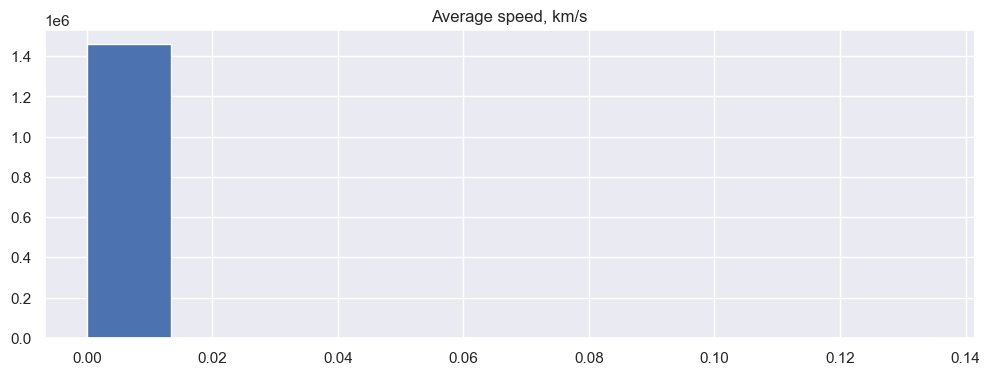

In [269]:
avg_speed = distance_haversine / np.expm1(y)
avg_speed.hist()
plt.title('Average speed, km/s')
plt.show()

As you can see from this histogram, there are outliers. Filter the data, for example by removing values greater than a certain percentile, and display again the distribution.

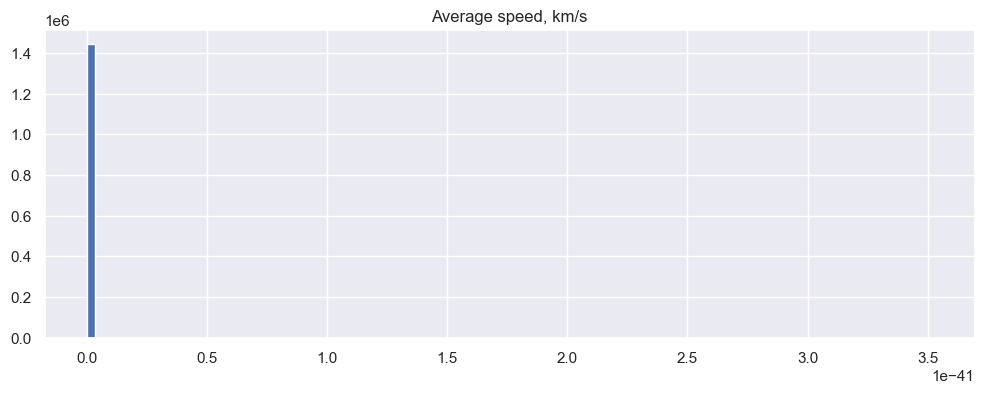

In [270]:
avg_speed[avg_speed<avg_speed.quantile(0.99)].hist(bins=100)
plt.title('Average speed, km/s')
plt.show()

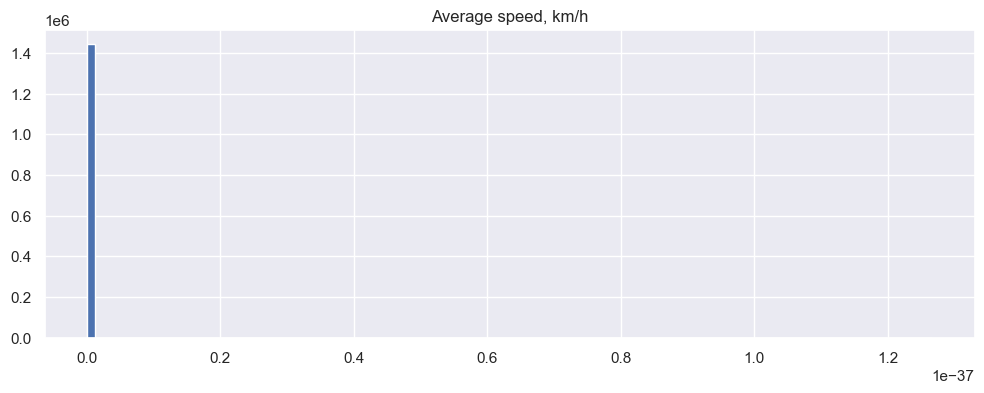

In [271]:
(avg_speed[avg_speed<avg_speed.quantile(0.99)]*3600).hist(bins=100)
plt.title('Average speed, km/h')
plt.show()

For each tuple (day of the week, time of day) calculate the median speed. Display a heatmap with the results.

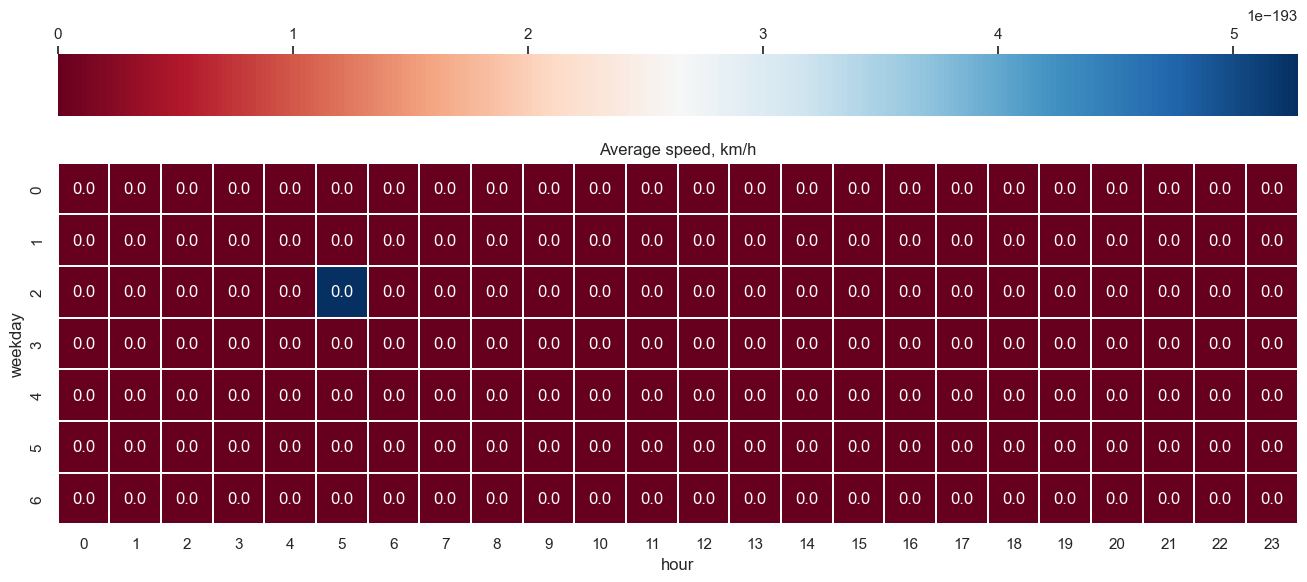

In [272]:
data_plot = avg_speed.groupby([X['weekday'], X['hour']]).median().rename('avg_speed').reset_index()
data_plot = data_plot.pivot(index='weekday', columns='hour', values='avg_speed')

f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(data_plot*3600, annot=True, fmt=".1f", linewidths=0.1, square=True, cmap="RdBu", cbar_kws=dict(use_gridspec=False, location="top"))
plt.title('Average speed, km/h')
plt.show()

**Warning** : The variable containing the speed must be dropped before training a linear model (cf. https://en.wikipedia.org/wiki/Multicollinearity).

**Question**: How can you interpret the graph above: when the speed is minimum and when it is maximum?

<font color='yellowgreen'>your text here</font>

Add new binary variables `high traffic trip` and `high speed trip` (don't use speed feature to calculate the values of these features).

In [273]:
def is_high_traffic_trip(X):
  return ((X['hour'] >= 8) & (X['hour'] <= 19) & (X['weekday'] >= 0) & (X['weekday'] <= 4)) | \
         ((X['hour'] >= 13) & (X['hour'] <= 20) & (X['weekday'] == 5))

def is_high_speed_trip(X):
  return ((X['hour'] >= 2) & (X['hour'] <= 5) & (X['weekday'] >= 0) & (X['weekday'] <= 4)) | \
         ((X['hour'] >= 4) & (X['hour'] <= 7) & (X['weekday'] >= 5) & (X['weekday'] <= 6))

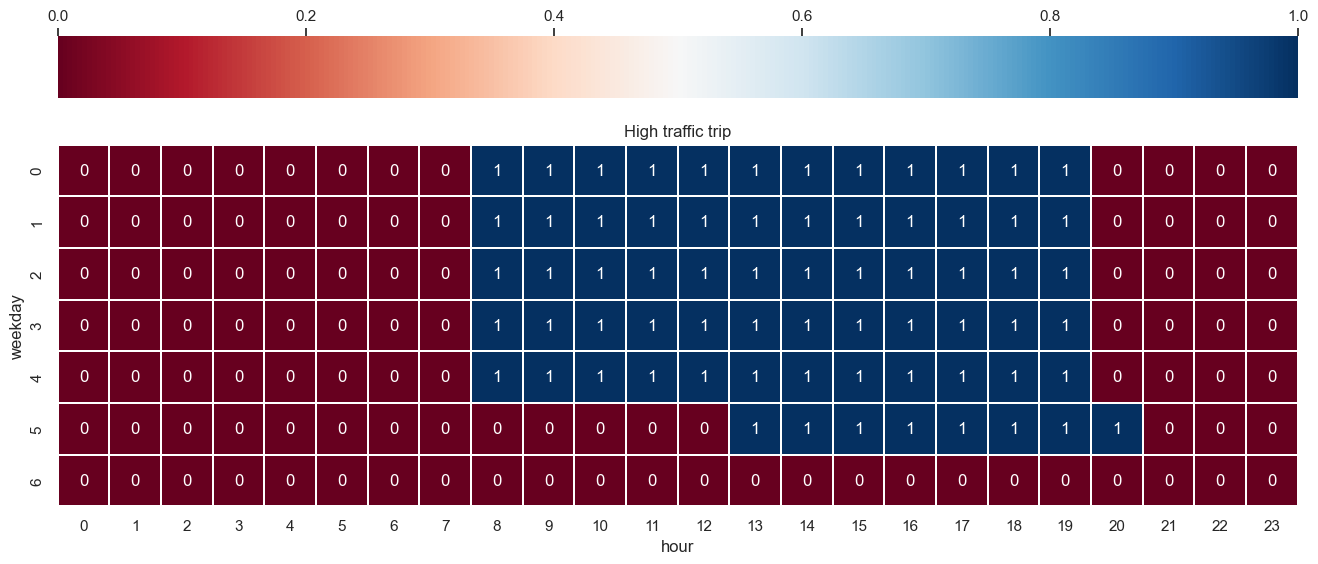

In [274]:
# test is_high_traffic_trip function
high_traffic_trip_vec = is_high_traffic_trip(X).astype(int).rename('is_high_traffic_trip')

data_plot = pd.concat([X[['weekday', 'hour']], high_traffic_trip_vec], axis=1)
data_plot = data_plot.groupby(['weekday', 'hour'])['is_high_traffic_trip'].mean().reset_index()
data_plot = data_plot.pivot(index='weekday', columns='hour', values='is_high_traffic_trip')

f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(data_plot, annot=True, fmt=".0f", linewidths=0.1, square=True, cmap="RdBu", cbar_kws=dict(use_gridspec=False, location="top"))
plt.title('High traffic trip')
plt.show()

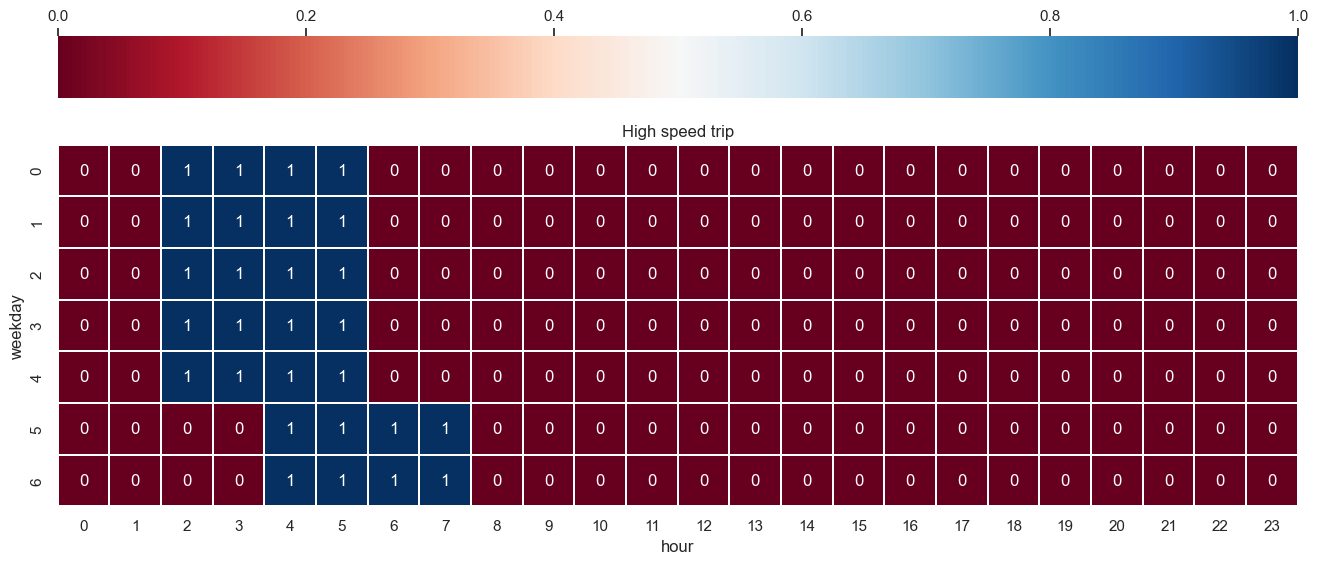

In [275]:
# test is_high_traffic_trip function
high_speed_trip_vec = is_high_speed_trip(X).astype(int).rename('is_high_speed_trip')

data_plot = pd.concat([X[['weekday', 'hour']], high_speed_trip_vec], axis=1)
data_plot = data_plot.groupby(['weekday', 'hour'])['is_high_speed_trip'].mean().reset_index()
data_plot = data_plot.pivot(index='weekday', columns='hour', values='is_high_speed_trip')

f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(data_plot, annot=True, fmt=".0f", linewidths=0.1, square=True, cmap="RdBu", cbar_kws=dict(use_gridspec=False, location="top"))
plt.title('High speed trip')
plt.show()

### 5.4. Outliers

On the map you can see some points that are quite far from Manhattan. Add new features: whether the trip starts or ends at such a point.

In [276]:
def is_rare_point(X, latitude_column, longitude_column, qmin_lat, qmax_lat, qmin_lon, qmax_lon):
  lat_min = X[latitude_column].quantile(qmin_lat)
  lat_max = X[latitude_column].quantile(qmax_lat)
  lon_min = X[longitude_column].quantile(qmin_lon)
  lon_max = X[longitude_column].quantile(qmax_lon)

  res = (X[latitude_column] < lat_min) | (X[latitude_column] > lat_max) | \
        (X[longitude_column] < lon_min) | (X[longitude_column] > lon_max)
  return res

In [277]:
latitude_column, longitude_column = "pickup_latitude", "pickup_longitude"

is_rare_point_vec = is_rare_point(X, latitude_column, longitude_column, 0.01, 0.995, 0, 0.95)
m = show_circles_on_map(data[~is_rare_point_vec].sample(1000), latitude_column, longitude_column, "blue")

rare_points = X[[latitude_column, longitude_column]][is_rare_point_vec]
color_rare = 'red'

for _, row in rare_points.sample(100).iterrows():
    folium.Circle(
        radius=100,
        location=(row[latitude_column], row[longitude_column]),
        color=color_rare,
        fill_color=color_rare,
        fill=True
    ).add_to(m)
m

In [278]:
latitude_column, longitude_column = "dropoff_latitude", "dropoff_longitude"

is_rare_point_vec = is_rare_point(X, latitude_column, longitude_column, 0.01, 0.995, 0.005, 0.95)
m = show_circles_on_map(data[~is_rare_point_vec].sample(1000), latitude_column, longitude_column, "blue")

rare_points = X[[latitude_column, longitude_column]][is_rare_point_vec]
color_rare = 'red'

for _, row in rare_points.sample(100).iterrows():
    folium.Circle(
        radius=100,
        location=(row[latitude_column], row[longitude_column]),
        color=color_rare,
        fill_color=color_rare,
        fill=True
    ).add_to(m)
m

### 5.5 Check new features

For each new categorical feature, display box plots showing the distribution of the target.

In [279]:
def step2_add_features(X):
  res = X.copy()
  distance_haversine = haversine_array(res.pickup_latitude, res.pickup_longitude, res.dropoff_latitude, res.dropoff_longitude)
  res['log_distance_haversine'] = np.log1p(distance_haversine)
  res['is_high_traffic_trip'] = is_high_traffic_trip(X).astype(int)
  res['is_high_speed_trip'] = is_high_traffic_trip(X).astype(int)
  res['is_rare_pickup_point'] = is_rare_point(X, "pickup_latitude", "pickup_longitude", 0.01, 0.995, 0, 0.95).astype(int)
  res['is_rare_dropoff_point'] = is_rare_point(X, "dropoff_latitude", "dropoff_longitude", 0.01, 0.995, 0.005, 0.95).astype(int)

  return res

X = step2_add_features(X)
X_train = step2_add_features(X_train)
X_test = step2_add_features(X_test)

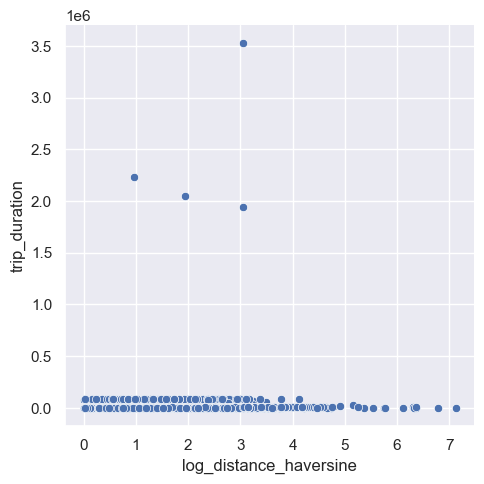

In [280]:
sns.relplot(data=X, x='log_distance_haversine', y=y)
plt.show()

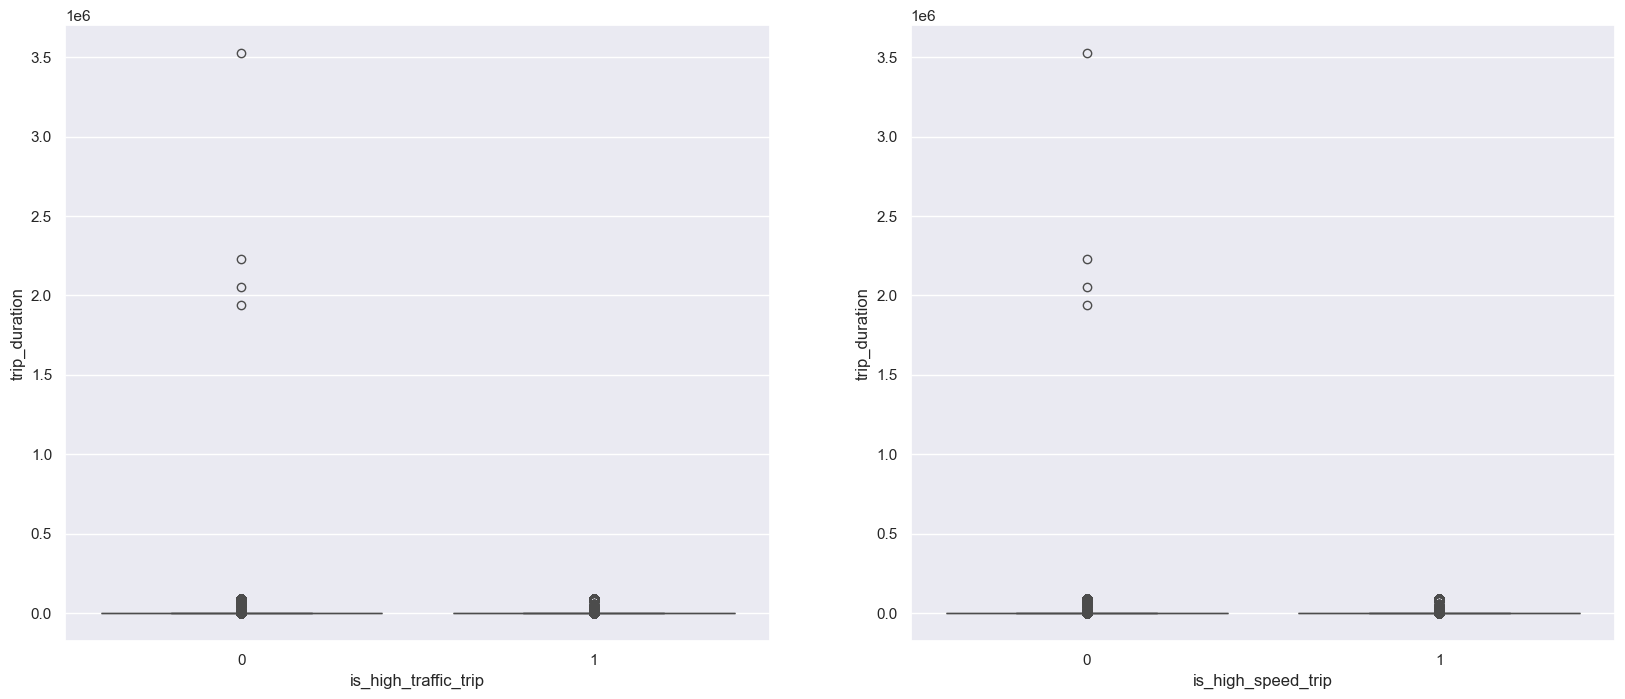

In [281]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.boxplot(x=X['is_high_traffic_trip'], y=y, ax=ax[0])
sns.boxplot(x=X['is_high_speed_trip'], y=y, ax=ax[1])
plt.show()

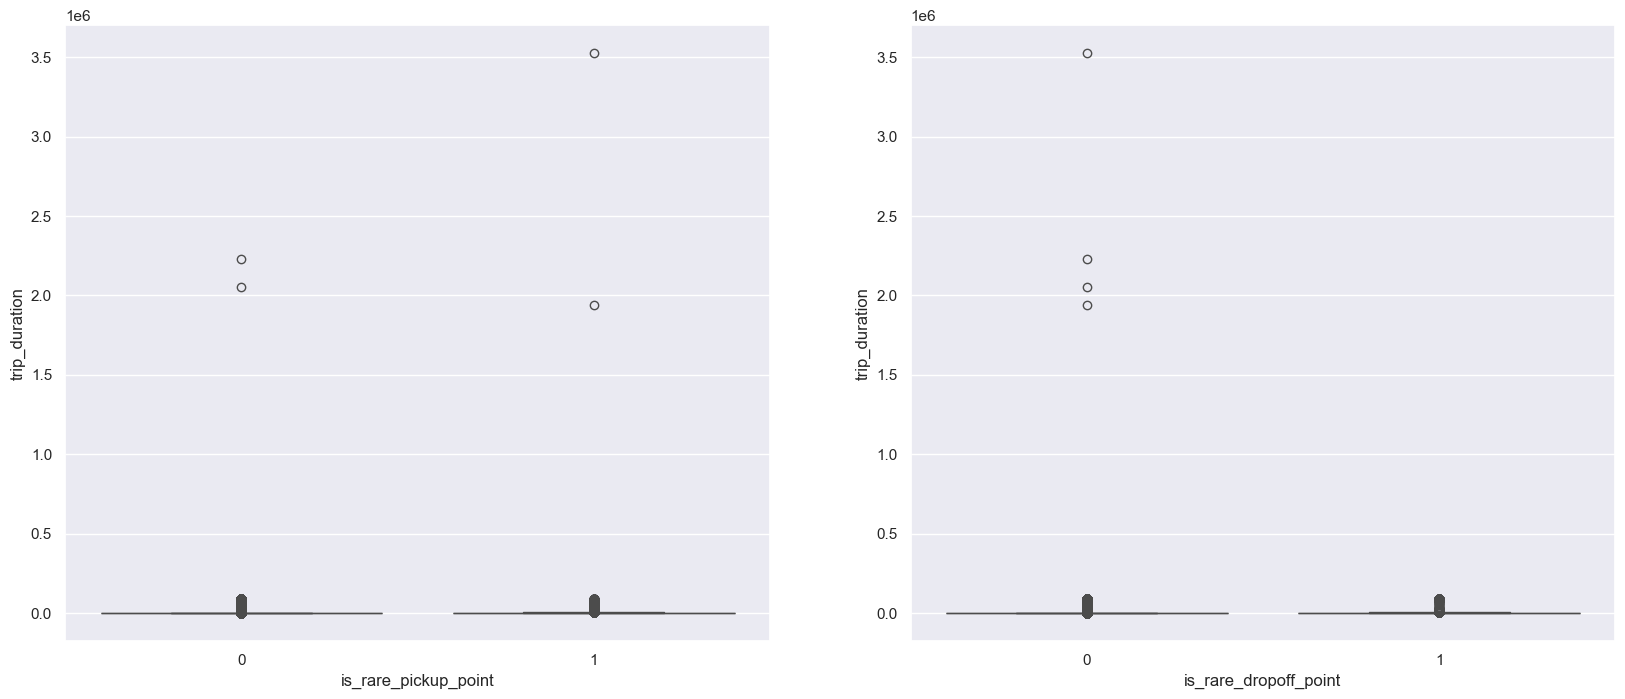

In [282]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.boxplot(x=X['is_rare_pickup_point'], y=y, ax=ax[0])
sns.boxplot(x=X['is_rare_dropoff_point'], y=y, ax=ax[1])
plt.show()

**Question**: Add your interpretation: could these variables be useful?

<font color='yellowgreen'>your text here</font>

### 5.6. Ridge regression

* Use only the features we have worked with up to now.
* Encode categorical features using `OneHotEncoder`.
* Scale numerical features using the `StandardScaler`.
* Train Ridge regression with the default settings.

In [286]:
X.columns


Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_date', 'weekday', 'month', 'hour',
       'abnormal_period', 'log_distance_haversine', 'is_high_traffic_trip',
       'is_high_speed_trip', 'is_rare_pickup_point', 'is_rare_dropoff_point'],
      dtype='object')

In [287]:
num_features = ['log_distance_haversine', 'hour',
                'abnormal_period', 'is_high_traffic_trip', 'is_high_speed_trip',
                'is_rare_pickup_point', 'is_rare_dropoff_point']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

Train RMSE = 0.4951
Test RMSE = 3332.6231
Test R2 = -0.0879


## Task 6. Other features analysis

### 6.1. `vendor_id`, `passenger_count`, `store_and_fwd_flag`

There are 3 more variables: `vendor_id`, `passenger_count` and `store_and_fwd_flag`. Display the unique values for each of them and the corresponding number of trips.

In [ ]:
X['vendor_id'].value_counts()

In [ ]:
X['passenger_count'].value_counts()

In [ ]:
X['store_and_fwd_flag'].value_counts()

Display the distribution of the target by the values of the following variables: `vendor_id`, `passenger_count` and `store_and_fwd_flag`.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

sns.boxplot(x=X['vendor_id'], y=y, ax=ax[0])
sns.boxplot(x=X['passenger_count'], y=y, ax=ax[1])
sns.boxplot(x=X['store_and_fwd_flag'], y=y, ax=ax[2])
plt.show()

**Question**: Add your interpretation of these graphs: do you think these features could be useful for the model?

<font color='yellowgreen'>your text here</font>

Change the `vendor_id` and `store_and_fwd_flag` variables so that their values are: $\{0;1\}$.

In [ ]:
def step3_process_features(X):
  res = X.copy()
  res['vendor_id'] = res['vendor_id'].map({1:0, 2:1})
  res['store_and_fwd_flag'] = res['store_and_fwd_flag'].map({'N':0, 'Y':1})
  res.loc[res['passenger_count'] > 6, 'passenger_count'] = 6

  return res

X = step3_process_features(X)
X_train = step3_process_features(X_train)
X_test = step3_process_features(X_test)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

sns.boxplot(x=X['vendor_id'], y=y, ax=ax[0])
sns.boxplot(x=X['passenger_count'], y=y, ax=ax[1])
sns.boxplot(x=X['store_and_fwd_flag'], y=y, ax=ax[2])
plt.show()

### 6.2. Ridge regression

* Use only the features we have worked with up to now.
* Encode categorical features using `OneHotEncoder`.
* Scale numerical features using the `StandardScaler`.
* Train Ridge regression with the default settings.

In [ ]:
X.columns

In [ ]:
# try 'vendor_id', 'store_and_fwd_flag'
num_features = ['log_distance_haversine', 'hour',
                'abnormal_period', 'is_high_traffic_trip', 'is_high_speed_trip',
                'is_rare_pickup_point', 'is_rare_dropoff_point',
                'vendor_id', 'store_and_fwd_flag']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

In [288]:
# try 'passenger_count'
num_features = ['log_distance_haversine', 'hour',
                'abnormal_period', 'is_high_traffic_trip', 'is_high_speed_trip',
                'is_rare_pickup_point', 'is_rare_dropoff_point',
                'passenger_count']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

Train RMSE = 0.4950
Test RMSE = 3332.6229
Test R2 = -0.0879


If adding new variables didn't improve the quality of the model, you can drop them.

In [ ]:
def undo_step3_process_features(X):
  res = X.copy()
  res.drop(columns=['vendor_id', 'store_and_fwd_flag', 'passenger_count'])

  return res

X = undo_step3_process_features(X)
X_train = undo_step3_process_features(X_train)
X_test = undo_step3_process_features(X_test)

## Task 7. Improve the model

### 7.1. Cleaning data

There are outliers in the data: trips with too short duration or too long distance. Display the distribution of the abovementionned variables, select observations corresponding to the values of these variables that could be considered as outliers and drop them from the sample.

Note that although these values appear to be outliers, the test sample will most likely contain objects with the "outlier" values of the target variable and/or the other variables. As a result, it is possible that cleaning up the training sample will lead to a deterioration in the quality of the test. However, it is always preferable to remove outliers to make the model more interpretable.

In [ ]:
X['log_distance_haversine'].hist(bins=100);

In [ ]:
d = X['log_distance_haversine']
d_min = d.quantile(0.01)
d_max = d.quantile(0.995)
d_new = d[(d > d_min) & (d < d_max)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.histplot(x=d_new, ax=ax[0])
ax[0].set(xlabel='log distance (haversine)')
sns.histplot(x=np.expm1(d_new), ax=ax[1])
ax[1].set(xlabel='distance (haversine)')
plt.show()

In [ ]:
y_min = y.quantile(0.005)
y_max = y.quantile(0.995)
y_new = y[(y > y_min) & (y < y_max)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.histplot(x=y_new, ax=ax[0])
ax[0].set(xlabel='log trip duration')
sns.histplot(x=np.expm1(y_new), ax=ax[1])
ax[1].set(xlabel='trip duration')
plt.show()

In [ ]:
def step4_remove_outliers(X, y):
  res = X.copy()

  d = res['log_distance_haversine']
  d_min = d.quantile(0.01)
  d_max = d.quantile(0.995)
  cond_distance = (d > d_min) & (d < d_max)

  y_min = y.quantile(0.005)
  y_max = y.quantile(0.995)
  cond_time = (y > y_min) & (y < y_max)

  cond_non_outliers = cond_distance & cond_time

  return X[cond_non_outliers], y[cond_non_outliers]

In [ ]:
X_temp, y_temp = step4_remove_outliers(X, y)
display(X.shape, y.shape)
display(X_temp.shape, y_temp.shape)
len(X_temp) / len(X)

In [ ]:
X_train, y_train = step4_remove_outliers(X_train, y_train)
X, y = pd.concat([X_train, X_test]), pd.concat([y_train, y_test])

In [ ]:
display(X.shape, y.shape)

There are many categorical variables. Some categories are very rare and using them can lead to overfitting. Try to combine (very) rare categories into fewer categories.

In [ ]:
X['weekday'].value_counts()

In [ ]:
X['month'].value_counts()

In [ ]:
def encode_weekday(x):
  if (x == 0): return 0
  if (x == 5): return 2
  if (x == 6): return 3
  return 1

def step5_process_categorical_features(X):
  res = X.copy()
  res['weekday'] = res['weekday'].apply(encode_weekday)

  return res

# test the function
step5_process_categorical_features(X)['weekday'].value_counts()

In [ ]:
X = step5_process_categorical_features(X)
X_train = step5_process_categorical_features(X_train)
X_test = step5_process_categorical_features(X_test)

Train the model on clean data and evaluate it.

In [ ]:
num_features = ['log_distance_haversine', 'hour',
                'abnormal_period', 'is_high_traffic_trip', 'is_high_speed_trip',
                'is_rare_pickup_point', 'is_rare_dropoff_point']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

### 7.2. Ridge vs. Lasso

Tune hyperparameters of `Lasso` and `Ridge` algorithms. Which algorithms gives the best result?

In [ ]:
from sklearn.linear_model import Lasso

num_features = ['log_distance_haversine', 'hour',
                'abnormal_period', 'is_high_traffic_trip', 'is_high_speed_trip',
                'is_rare_pickup_point', 'is_rare_dropoff_point']
cat_features = ['weekday', 'month']
train_features = num_features + cat_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_features),
    ('scaling', StandardScaler(), num_features)]
)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=0.5))
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred_train = model.predict(X_train[train_features])
y_pred_test = model.predict(X_test[train_features])

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))
print("Test R2 = %.4f" % r2_score(y_test, y_pred_test))

In [ ]:
model.named_steps['regression'].coef_

In [ ]:
pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

params = {'regression__alpha': np.logspace(-2, 2, 20)}

In [ ]:
from sklearn.model_selection import GridSearchCV

gs_ridge = GridSearchCV(pipeline_ridge, [params], scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, verbose=2)
gs_ridge.fit(X_train[train_features], y_train)

best_alpha_ridge = gs_ridge.best_params_["regression__alpha"]
print("Best alpha (Ridge) = %.4f" % best_alpha_ridge)

plt.plot(params['regression__alpha'], -gs_ridge.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score (RMSE)");

In [ ]:
gs_ridge = GridSearchCV(pipeline_ridge, [params], scoring="r2", cv=5, n_jobs=-1, verbose=2)
gs_ridge.fit(X_train[train_features], y_train)

best_alpha_ridge = gs_ridge.best_params_["regression__alpha"]
print("Best alpha (Ridge) = %.4f" % best_alpha_ridge)

plt.plot(params['regression__alpha'], gs_ridge.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score (r2)")
plt.ylim(0, 1)
plt.show()

In [ ]:
gs_ridge.cv_results_["mean_test_score"]

In [ ]:
gs_lasso = GridSearchCV(pipeline_lasso, [params], scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, verbose=2)
gs_lasso.fit(X_train[train_features], y_train)

best_alpha_lasso = gs_lasso.best_params_["regression__alpha"]
print("Best alpha (Lasso) = %.4f" % best_alpha_lasso)

plt.plot(params['regression__alpha'], -gs_lasso.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [ ]:
gs_lasso = GridSearchCV(pipeline_ridge, [params], scoring="r2", cv=5, n_jobs=-1, verbose=2)
gs_lasso.fit(X_train[train_features], y_train)

best_alpha_lasso = gs_lasso.best_params_["regression__alpha"]
print("Best alpha (Lasso) = %.4f" % best_alpha_lasso)

plt.plot(params['regression__alpha'], gs_lasso.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score (r2)")
plt.set_ylim(0, 1)
plt.show()

### 7.3. DecisionTreeRegressor and ensembles

Use DecisionTreeRegressor and ensembles of trees (Random Forest and Gradient Boosting) to try to improve the model.



In [ ]:
# your code here